In [ ]:
from typing import Annotated, TypedDict, List, Dict, Any, Optional, Union, Literal
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser, create_sync_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_community.agent_toolkits import FileManagementToolkit
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from IPython.display import Image, display
import gradio as gr
import uuid
from dotenv import load_dotenv
import operator
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool
from playwright.async_api import async_playwright
from datetime import datetime, date, timedelta
from langchain_core.tools import tool
import nest_asyncio
import textwrap
load_dotenv(override=True)

True

# Tools

In [143]:
# google search tool
serper = GoogleSerperAPIWrapper()
web_search_tool =Tool(
    name="web_search_tool",
    func=serper.run,
    description="Use this tool when you want to get the results of an online web search and make recommendations based on the results."
)

currency_search_tool =Tool(
    name="web_search_tool",
    func=serper.run,
    description="Use this tool when you want to get the results of an online web search on the currency of a country."
)

In [3]:
#playwright tools (browser use)
async def playwright_tools():
    playwright = await async_playwright().start()
    browser = await playwright.chromium.launch(headless=False)
    toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=browser)
    return toolkit.get_tools(), browser, playwright


browser_tools, browser, playwright = await playwright_tools()

In [4]:
browser_tools

[ClickTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\1997e\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=138.0.7204.23>),
 NavigateTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\1997e\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=138.0.7204.23>),
 NavigateBackTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\1997e\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=138.0.7204.23>),
 ExtractTextTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\1997e\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=138.0.7204.23>),
 ExtractHyperlinksTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\1997e\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=138.0.7204.23>),
 GetElementsTool(async_browser=<Brows

In [5]:
# date tool to get dates in the future
@tool
def date_tool(input: str) -> str:
    """You can suggest dates in the future"""
    system_message = f"You can suggest dates in the future Assume today is {datetime.now().strftime("%Y-%m-%d")}. Recommend dates strictly after today."
    llm = ChatOpenAI(model="gpt-4o-mini", description=system_message)
    return llm.invoke(input)


In [6]:
# emailing tools
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
@tool
def subject_writer(input: str) -> str:
    """You can write a subject for an travel planning email"""
    llm = ChatOpenAI(model="gpt-4o-mini")
    return llm.invoke(input)

@tool
def html_converter(input: str) -> str:
    """You can convert a text body to an HTML email body. You are given a text body which might have some markdown and you need to convert it to an HTML email body with simple, clear, compelling layout and design."""
    llm = ChatOpenAI(model="gpt-4o-mini")
    return llm.invoke(input)

def send_html_email(subject: str, html_body: str, recipient: str) -> Dict[str, str]:
    """You can send an email to a recipient with the given subject and HTML body."""
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("1997.e.t@gmail.com")  # Change to your verified sender
    to_email = To(recipient)  # Change to your recipient
    content = Content("text/html", html_body)
    mail = Mail(from_email, to_email, subject, content).get()
    response = sg.client.mail.send.post(request_body=mail)
    return {"status": "success"}

email_tools = [subject_writer, html_converter]

In [8]:
# tools to allow llm to access files
def get_file_tools():
    toolkit = FileManagementToolkit(root_dir="sandbox") # sandbox is the folder the llm can access
    return toolkit.get_tools()
file_tools = get_file_tools()

# Structured Outputs and State

In [ ]:
class Location(BaseModel):
    country: str = Field(description="The country of the location")
    city: str = Field(description="The city of the location")
    address: Optional[str] = Field(description="The precise address of the location")

class InitialInformation(BaseModel):
    # email_address: str = Field(description="The email address of the user")
    home_location: Optional[Location] = Field(description="The user's home location.")
    trip_locations: List[Location] = Field(description="The locations of the trip")
    start_date: Optional[date] = Field(description="The start date of the trip in the format YYYY-MM-DD after today")
    end_date: Optional[date] = Field(description="The end date of the trip in the format YYYY-MM-DD after today and after the start date")
    duration: int = Field(description="The length of the trip in days")
    num_adults: int = Field(description="The number of adults in the trip")
    num_children: int = Field(description="The number of children in the trip")
    budget: Optional[int] = Field(description="The budget for the trip in USD")
    other_preferences: Optional[List[str]] = Field(description="List of user preferences that do not fit into the other fields")
    home_currency: Optional[str] = Field(description="The currency of the user's home location")
    completed: bool = Field(description="Whether the user has provided all the information needed")

class WillRecordInfo(BaseModel):
    message: str = Field(description="The reply to the user")
    will_record: bool = Field(description="Whether the user's message contains valid information")

class Activity(BaseModel):
    name: str = Field(description="The name of the activity")
    description: str = Field(description="The description of the activity")
    location: Location = Field(description="The location of the activity")
    time: str = Field(description="The time of the activity in the format HH:MM")
    notes: Optional[str] = Field(description="Notes about the activity")
    cost: int = Field(description="The monetary cost of the activity, currency based on the location")
    activity_link: str = Field(description="the web link or url to the activity or location")

class Meal(BaseModel):
    name: Literal["breakfast", "lunch", "dinner"] = Field(description="The name of the meal")
    food_options: List[str] = Field(description="The list of food options available for the meal")
    location: Location = Field(description="The location of the meal")
    time: str = Field(description="The time of the meal in the format HH:MM")
    notes: Optional[str] = Field(description="Notes about the meal")

class Accomodation(BaseModel):
    name: str = Field(description="The name of the accomodation")
    location: Location = Field(description="The location of the accomodation")
    check_in_time: str = Field(description="The time the accomodation is available to check in in the format HH:MM")
    check_in_date: date = Field(description="The date the user will check in to the accomodation")
    check_out_time: str = Field(description="The time the accomodation is available to check out in the format HH:MM")
    check_out_date: date = Field(description="The date the user will check out from the accomodation")
    cost: int = Field(description="The cost of the accomodation")
    notes: Optional[str] = Field(description="Notes about the accomodation")
    accomodation_link: str = Field(description="the web link or url to the accomodation website")

class FlightOption(BaseModel):
    airline: str = Field(description="the airline providing this flight")
    flight_departure_time: str = Field(description="The time the flight departs from the starting airport in HH:MM")
    flight_duration: str = Field(description="The duration of the flight in the format x hours, y minutes")
    cost: int = Field(description="The cost of the flight")
    notes: str = Field(description="any notes the user should know about the flight")
    flight_link: str = Field(description="the web link or url to the flight from the airline website")

class FlightRoute(BaseModel):
    from_loc: Location = Field(description="Start airport location of the flight")
    to_loc: Location = Field(description="Destination airport location of the flight")
    flight_date: date = Field(description="the date the flight leaves")
    flight_options: List[FlightOption] = Field("The list of flight options for this flight route")
    
class ItineraryItem(BaseModel):
    # one item represents one day of the trip
    item_date: date = Field(description="The date of the day in the format YYYY-MM-DD")
    activities: List[Activity] = Field(description="The list of activities of the day")
    meals: List[Meal] = Field(description="The list of meals of the day")
    is_flying_day: bool = Field(description="Whether there will be airplane travel on this day")
    accomodation: Optional[Accomodation] = Field(description="The accomodation for the day")

class ItineraryDetails(BaseModel):
    items: List[ItineraryItem] = Field(description="The itinerary of the trip")
    flights: List[FlightRoute] = Field(description="The list of flight routes")
    completed: bool = Field(description="Whether the itinerary is complete")

class ActivityOutline(BaseModel):
    name: str = Field(description="The name of the activity")
    brief_description: str = Field(description="A brief description of the activity")
    location: Location = Field(description="The location of the activity")

class ItemOutline(BaseModel):
    item_date: date = Field(description="The date of the day in the format YYYY-MM-DD")
    activity_outlines: List[ActivityOutline] = Field(description="a list of activity outlines for that day")
    is_flying_day: bool = Field(description="Whether there will be airplane travel on this day")

class ItineraryOutline(BaseModel):
    item_outlines: List[ItemOutline] = Field(description = "The list of item outlines where each item outline is an outline for a day of the trip")

class MyEmail(BaseModel):
    html_body: str = Field(description="The HTML body of the email")
    subject: str = Field(description="The subject of the email")

class ItineraryOutlineFeedback(BaseModel):
    feedback: Optional[str]
    criteria_met: bool


In [289]:
# the main state
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    initial_information: Optional[InitialInformation]
    record_initial_information: bool
    done_recording: bool
    itinerary_outline: Optional[ItineraryOutline]
    itinerary_outline_feedback: Optional[ItineraryOutlineFeedback]
    itinerary_details: Optional[ItineraryDetails]
    email_content: Optional[str]
    email: Optional[MyEmail]
    email_sent: bool
    
# item state
# used to plan out each day of the trip
class Item_State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    feedback: Optional[str]
    item_outline: ItemOutline
    itinerary_item: Optional[ItineraryItem]




# Helper functions

In [303]:
# routers
def gather_or_plan(state: State) -> str:
    if state["email_sent"]:
        return "thanker"
    print("in gather or plan edge")
    initial_information = state["initial_information"]
    if initial_information is None:
        return "information_gatherer"
    elif initial_information.completed:
        return "itinerary_planner"
    else:
        return "information_gatherer"

def outline_criteria_met(state: State) -> str:

    if state["itinerary_outline_feedback"].criteria_met:
        return "END"
    else:
        return "itinerary_outliner"

def record_or_prompt(state: State) -> str:
    if state["record_initial_information"]:
        return "information_recorder"
    else:
        return "END"

def confirm_info_or_prompt(state: State) -> str:
    if state["initial_information"] is not None:
        if state["initial_information"].completed:
            return "information_confirmer"
    else: 
        return "information_gatherer"

In [1]:
# check if initial information is completed
# email_address: str = Field(description="The email address of the user")
# home_location: Optional[Location] = Field(description="The user's home location.")
# trip_locations: List[Location] = Field(description="The locations of the trip")
# start_date: Optional[date] = Field(description="The start date of the trip in the format YYYY-MM-DD after today")
# end_date: Optional[date] = Field(description="The end date of the trip in the format YYYY-MM-DD after today and after the start date")
# duration: int = Field(description="The length of the trip in days")
# num_adults: int = Field(description="The number of adults in the trip")
# num_children: int = Field(description="The number of children in the trip")
# budget: Optional[int] = Field(description="The budget for the trip in USD")
# other_preferences: Optional[List[str]] = Field(description="List of user preferences that do not fit into the other fields")
# home_currency: Optional[str] = Field(description="The currency of the user's home location")
# completed: bool = Field(description="Whether the user has provided all the information needed")

def check_info_completion(info: InitialInformation) -> bool:
    if info.home_location is not None and info.home_currency is not None and info.start_date is not None and info.end_date is not None and info.duration > 0 and info.num_adults > 0 and info.duration is not None and info.budget is not None and info.home_currency is not None:
        return True
    else:
        return False

NameError: name 'InitialInformation' is not defined

In [12]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[Tools use]"
            conversation += f"Assistant: {text}\n"
    return conversation

In [13]:
# parsers
def location_parser(l: Location) -> str:
    ret_string = f"""
    location country: {l.country}
    location city: {l.city}
    location address: {l.address}
    """
    return ret_string

def activity_parser(act: Activity) -> str:
    ret_string = f"""
    activity name: {act.name}
    activity description: {act.description}
    activity location: {location_parser(act.location)}
    activity time: {act.time}
    activity notes: {act.notes}
    activity link: {act.activity_link}
    
    """
    return ret_string

def activities_parser(acts: List[Activity]) -> str:
    ret_string = ""
    for act in acts:
        ret_string += activity_parser(act)
    return ret_string

def meal_parser(meal: Meal) -> str:
    ret_string = f"""
    meal name: {meal.name}
    food options: {meal.food_options}
    meal location: {location_parser(meal.location)}
    meal time: {meal.time}
    meal notes: {meal.notes}
    
    """
    return ret_string

def meals_parser(meals: List[Meal]) -> str:
    ret_string = ""
    for meal in meals:
        ret_string += meal_parser(meal)
    return ret_string

def flight_options_parser(flight_option: FlightOption) -> str:
    ret_string = f"""
    airline: {flight_option.airline}
    flight departure time: {flight_option.flight_departure_time}
    flight duration: {flight_option.flight_duration}
    flight cost: {flight_option.cost}
    notes about the flight: {flight_option.notes}
    flight link: {flight_option.flight_link}

    """
    return ret_string
    

def flight_route_parser(flight_route: FlightRoute) -> str:
    ret_string = f"""
    Here are the flight options to travel from {flight_route.from_loc} to {flight_route.to_loc} on {flight_route.flight_date}
    """
    for f in flight_route.flight_options:
        ret_string += flight_options_parser(f)
    return ret_string

def itinerary_item_parser(item: ItineraryItem) -> str:
    ret_string = f"""
    itinerary item date: {item.item_date}
    itinerary item activities: {activities_parser(item.activities)}
    itinerary item meals: {meals_parser(item.meals)}
    
    """
    return ret_string

def itinerary_details_parser(it_details: ItineraryDetails) -> str:
    ret_string = "Itinerary:\n"
    for i in it_details.items:
        ret_string += itinerary_item_parser(i)
    for f in it_details.flights:
        ret_string += flight_route_parser(f)
    return ret_string

def activity_outline_parser(act_outline: ActivityOutline) -> str:
    return f"""activity name: {act_outline.name},  location: {location_parser(act_outline.location)}\n
    a brief description of the activity: {act_outline.brief_description}\n
    """

def item_outline_parser(item_outline: ItemOutline) -> str:
    ret_string = f"""Item date: {item_outline.item_date}
    Activities:\n
    """
    for a in item_outline.activity_outlines:
        ret_string += activity_outline_parser(a)
    
    ret_string += f"Flying today: {item_outline.is_flying_day}\n"
    return ret_string

def outline_parser(outline: ItineraryOutline) -> str:
    ret_string = "outline: \n"
    for item in outline.item_outlines:
        ret_string += f"{item_outline_parser(item)}\n"
    return ret_string

class ItineraryOutlineFeedback(BaseModel):
    feedback: Optional[str]
    criteria_met: bool

def outline_feedback_parser(iof: ItineraryOutlineFeedback) -> str:
    ret_string = f"""criteria met: {iof.criteria_met}
    Feedback:
    {iof.feedback}
    """
    return ret_string


# Item Planning Graph Agents

In [14]:
def item_researcher(state: State) -> State:
    print("researching item")
    # takes 
    return state

In [15]:
def item_feedback(state: State) -> State:
    print("providing item feedback")
    return state 

# Flight Planning Graph Agents

In [16]:
def flight_finder(state: State) -> State:
    print("in flight finder")
    # takes 
    return state

# Building the sub graphs

In [17]:
def build_item_graph():
    graph_builder = StateGraph(Item_State)
    graph_builder.add_node("item_researcher", item_researcher)


    graph_builder.add_node("information_gatherer", information_gatherer)
    graph_builder.add_node("itinerary_planner", itinerary_planner)
    graph_builder.add_node("itinerary_formatter", itinerary_formatter)
    graph_builder.add_node("email_formatter", email_formatter)
    graph_builder.add_node("thanker", thanker) # we have this thanker node to make the user only use this system once. after they get an email, refresh to restart
    # graph_builder.add_edge(START, "information_gatherer")
    graph_builder.add_conditional_edges(START, gather_or_plan, {"itinerary_planner": "itinerary_planner", "information_gatherer": "information_gatherer", "thanker": "thanker"})

    graph_builder.add_edge("information_gatherer", END)
    graph_builder.add_edge("itinerary_planner", "itinerary_formatter")
    graph_builder.add_edge("itinerary_formatter", "email_formatter")
    graph_builder.add_edge("email_formatter", END)
    memory = MemorySaver()
    graph = graph_builder.compile(checkpointer=memory)
    return graph

# Main Graph Agents

In [ ]:
# initialize llm
# from langgraph.prebuilt.chat_agent_executor import StructuredResponseSchema

# information gathering agent
def information_gatherer(state: State) -> State:
    print("in information gathering agent")
    # print(state)
    current_initial_information = state["initial_information"]
    if current_initial_information is None:
        current_initial_information = InitialInformation(
        home_location = None,
        trip_locations = [],
        start_date = None,
        end_date = None,
        duration = 0,
        num_adults = 0,
        num_children = 0,
        budget = None,
        home_currency = None,
        other_preferences = [],
        completed = False
        )
    last_response = state["messages"][-1].content # get the user's message
    # print("last response: ", last_response)
    gathered_information = f"""here is the current gathered information:
        home_location: {current_initial_information.home_location}
        trip_locations: {current_initial_information.trip_locations}
        start_date: {current_initial_information.start_date}
        end_date: {current_initial_information.end_date}
        duration: {current_initial_information.duration}
        num_adults: {current_initial_information.num_adults}
        num_children: {current_initial_information.num_children}
        budget: {current_initial_information.budget}
        other_preferences: {current_initial_information.other_preferences}
        home_currency: {current_initial_information.home_currency}
        """
    chat_history = format_conversation(state["messages"])
    
    system_message = f"""You are an expert travel planner that can use tools to complete tasks. You use friendly and simple language to engage the user.
    Your task is to prompt the user for specific information to help them create their idea trip.
    The specific information you need to gather are:
    - the user's email address
    - the user's home location (city and country)
    - locations the user wants to visit
    - the dates when the user wants to travel. Dates must be in the future and the end date must be after the start date.
    - the duration of the trip in days (the number of days the user wants to travel). If the user provides exact start and end dates, the duration is the number of days between the two dates.
    - the number of adults who will be travelling (there must be at least 1 adult)
    - the number of children who will be travelling
    - the budget for the trip
    - the currency of the user's home location. You may infer this when the user provides their home location
    - any other preferences the user has (such as what the user likes and dislikes)

    Always end your responses with questions that get more specific information from the user, focus on getting the information that are still None
    If the user's message is ambiguous, prompt them for clarification.
    Use the following gathered information and chat history to guide your response to the user. 
    gathered information:
    {gathered_information} 
    
    chat history: 
    {chat_history}
    
    If the user provides new or valid information, return the will_record output as True
    Examples of valid information:
    - user provides the location they would like to travel to
        examples: 
        "Hi, I'd like to travel to tokyo!" trip location = tokyo
        "I'm thinking of going to Moscow" trip location = moscow
    - user provides their home location
        examples:
        "I currently reside in Singapore"; home location = Singapore

    If the user gives invalid information, return the will_record output as False
    Examples of invalid information:
    - user provides dates that are in the past
    - user says they want to travel to a location not on earth
    - user wants to travel to their home location
    - user provides ambiguous information
        example of ambiguous information:
        "I want to go to Europe"; this is ambgiuous because it does not specify a country or city
        "I'm travelling with a family of 4"; we cannot assume this means 2 adults and 2 children since it may be 1 adult and 3 children or 3 adults and 1 child. This is ambiguous and therefore invalid information.
        "Hi, how are you?"; This does not provide any information related to the specific information you are trying to gather, therefore it is not valid inforamtion.

    Your response should usually contain will_record = True unless you have good reason against it.
    """
    


    information_gatherer_agent = create_react_agent(
        model="gpt-4o-mini",
        tools=[web_search_tool,date_tool],
        prompt=system_message,
        response_format = WillRecordInfo
    )
    response = information_gatherer_agent.invoke({"messages": [{"role": "user", "content": last_response}]})
    print("response: ", response)
    new_state = {
            "messages": response["structured_response"].message,
            "record_initial_information": response["structured_response"].will_record
    }

    return new_state
    

In [ ]:
# user info filler
def information_recorder(state: State) -> State:
    print("in information filling agent")
    current_initial_information = state["initial_information"]
    if current_initial_information is None:
        current_initial_information = InitialInformation(
        home_location = None,
        trip_locations = [],
        start_date = None,
        end_date = None,
        duration = 0,
        num_adults = 0,
        num_children = 0,
        budget = None,
        home_currency = None,
        other_preferences = [],
        completed = False
        )
    chat_history = format_conversation(state["messages"])
    system_message = f"""You are an expert recorder. Your task is to record user information from a given conversation. Today's date is: {datetime.now().strftime("%Y-%m-%d")}
    Before you record the information, you must validate it against some guidelines
    - only record dates that are in the future
    - only record end dates that are after the start dates
    If the user does not provide information do not make up information

    Output the recorded information in your response
    """

    user_message = f"""Use the chat history and current state of the user's information to populate your output.
    Only use the information you find in the chat history to populate your output. Do not make up information.
    You may use the home_location to inform the home_currency
    Here is the current state of the user's information:
        home_location: {current_initial_information.home_location}
        trip_locations: {current_initial_information.trip_locations}
        start_date: {current_initial_information.start_date}
        end_date: {current_initial_information.end_date}
        duration: {current_initial_information.duration}
        num_adults: {current_initial_information.num_adults}
        num_children: {current_initial_information.num_children}
        budget: {current_initial_information.budget}
        home_currency: {current_initial_information.home_currency}
        other_preferences: {current_initial_information.other_preferences}
    Here is the chat history with the user:
    {chat_history}

    Here is the current date: {datetime.now().strftime("%Y-%m-%d")}


    Here are some examples:
    Example 1:
    current state of the user's information:
        email_address: None
        home_location: None
        trip_locations: None
        start_date: None
        end_date: None
        duration: None
        num_adults: None
        num_children: None
        budget: None
        home_currency: None
        other_preferences: None
    Here is the chat history with the user:
    User: Hi, I'd like to plan my trip. 
    Assistant: Sure! Please give me the dates you wish to travel
    User: Dec 1 to Dec 10
    Assistant: Thank you! And could you please provide your home city and country?
    User: London, England
    Assisant: Great! Now where would you like to travel to?
    
    Expected Output:
        email_address: None
        home_location: Location(city="London", Country="England", address = None)
        trip_locations: None
        start_date: date(2025,12,1)
        end_date: date(2025,12,10)
        duration: None
        num_adults: None
        num_children: None
        budget: None
        home_currency: GBP
        other_preferences: None

    Explanation:
        Since the user only provided their desired travel dates and home_location, you populate the start_date, end_date, and home_location field. You also use your currency tool to look up and populate the home_currency field since the home location of England's currency 
        is the Great British Pound: GBP
        other fields remain unpopulated because they were not in the chat history

    Example 2:
    current state of the user's information:
        email_address: fifty2@gmail.com
        home_location: None
        trip_locations: None
        start_date: None
        end_date: None
        duration: None
        num_adults: None
        num_children: None
        budget: None
        home_currency: None
        other_preferences: None
    Here is the chat history with the user:
    User: Hi, I have 3 children and I want to travel to a nearby universal studios. I live in Johor Bahru in Malaysia. Where should my husband and I go? 
    Assistant: Hello! Since you are in JB, Malaysia, I'd recommend going to the universal studios in Singapore! It's a nearby location that could be fun for your family!
    
    Expected Output:
        email_address: fifty2@gmail.com
        home_location: Location(city="Johor Bahru", Country="Malaysia", address = None)
        trip_locations: None
        start_date: None
        end_date: None
        duration: None
        num_adults: 2
        num_children: 3
        budget: None
        home_currency: Malaysian Ringgit
        other_preferences: None

    Explanation:
        First, we have kept the information present in the current state of the user's information, which is their email address in this case.
        We hav also update their home location because it was given to us, as well as the number of children and adults. 3 children were mentioned, and the user also mentioned herself and her husband.
        Note that we did not updated the trip_locations to include universal studios Singapore. This is because the user has not confirmed that that is where they want to go. This was only a recommendation from the assistant.
    
    Example 3:
    current state of the user's information:
        email_address: None
        home_location: Location(city="Moscow", Country="Russia", address = None)
        trip_locations: Location(city="Singapore", Country="Singapore")
        start_date: None
        end_date: None
        duration: None
        num_adults: 1
        num_children: 0
        budget: None
        home_currency: None
        other_preferences: None
    Here is the chat history with the user:
    User: I'd like to go to singapore!
    Assistant: Awesome! What dates are you thinking of going?
    User: I think I actually want to travel to Chicago instead.
    Assistant: Sure! Chicago is a great travel destination as well with lots of culture to explore! When would you like to go?
    
    Expected Output:
        email_address: None
        home_location: Location(city="Moscow", Country="Russia", address = None)
        trip_locations: Location(city="Chciago", Country="USA")
        start_date: None
        end_date: None
        duration: None
        num_adults: 1
        num_children: 0
        budget: None
        home_currency: None
        other_preferences: None

    Explanation:
        The user decided that they wanted to go to chicago instead of singapore based on the chat history. Thus, the output reflects their decision to go to Chicago, and not to Singapore.
    """

    information_recorder_agent = create_react_agent(
        model="gpt-4o",
        tools=[currency_search_tool],
        prompt=system_message,
        response_format = InitialInformation
    )
    response = information_recorder_agent.invoke({"messages": [{"role": "user", "content": user_message}]})
    update_initial_information = response["structured_response"]
    print("got response")
    print(update_initial_information)
    update_initial_information = InitialInformation(
        # email_address = response["structured_response"].email_address,
        home_location = response["structured_response"].home_location,
        trip_locations = response["structured_response"].trip_locations,
        start_date = response["structured_response"].start_date,
        end_date = response["structured_response"].end_date,
        duration = response["structured_response"].duration,
        num_adults = response["structured_response"].num_adults,
        num_children = response["structured_response"].num_children,
        budget = response["structured_response"].budget,
        home_currency = response["structured_response"].home_currency,
        other_preferences = response["structured_response"].other_preferences,
        completed = False
    )

    if check_info_completion(update_initial_information):
        update_initial_information.completed = True
    
    new_state = {
        "initial_information": update_initial_information
    }
    return new_state

In [294]:
def get_most_recent_human_message(state):
    """
    Retrieves the most recent HumanMessage from the LangGraph state.
    """
    if "messages" in state and isinstance(state["messages"], list): 
        for message in reversed(state["messages"]):
            if isinstance(message, HumanMessage): 
                return message
    return None

In [ ]:
def information_confirmer(state: State) -> State: 
    # last_response = get_most_recent_human_message(state) # get the user's most recent message
    current_initial_information = state["initial_information"]
    trip_locations = ""
    for loca in current_initial_information.trip_locations:
        trip_locations += location_parser(loca)
    response = f"""Here's the info I've gathered so far
    your email address is: {current_initial_information.email_address}
    Locations:
    your journey will begin from: {location_parser(current_initial_information.home_location)}
    You are going to these places: 
    {trip_locations}
    Dates:
    You will be flying out on {current_initial_information.start_date}
    You'll return home on {current_initial_information.end_date}
    You will be travelling for {current_initial_information.duration} days
    People:
    The number of adults travelling (including you) is: {current_initial_information.num_adults}
    The number of children travelling with you is: {current_initial_information.num_children}
    Finances:
    This is your budget: {current_initial_information.budget}
    Preferences:
    These are some of your preferences: {current_initial_information.other_preferences}

    If this is correct, please confirm by clicking the bottom right button. Any other input will assume some of the information is incorrect.
    """
    # we reset the completed parameter if there is a response
    current_initial_information.completed = False
    new_state = {
        "done_recording": False,
        "initial_information": current_initial_information
    }
    return new_state

In [220]:
async def itinerary_outliner(state: State) -> State:
    print("in travel planner")
    user_info = state["initial_information"]

    gathered_information = f"""gathered information:
        home_location: {user_info.home_location}
        trip_locations: {user_info.trip_locations}
        start_date: {user_info.start_date}
        end_date: {user_info.end_date}
        duration: {user_info.duration}
        num_adults: {user_info.num_adults}
        num_children: {user_info.num_children}
        budget: {user_info.budget}
        home_currency: {user_info.home_currency}
        other_preferences: {user_info.other_preferences}
        """
    system_message = f"""You are an expert travel planner that should use tools to search the web to plan an itinerary for the user. 
        You will be given a set of information that you should use to plan the itinerary.
        information will include home location, trip locations, start date, end date, duration in days, number of adults, number of children, budget, and other preferences.
        Your task is to create a day by day itinerary for the user. Focus on finding activities based on the user's preferences and the trip locations.
        You must include all the trip locations in the itinerary. spreading the trip locations out over the duration of the trip as evenly as possible while accounting for travel time.
        Once you visit a trip location, you should not visit it again.
        You should use the following guidelines while planning:
        - each day should be a separate item in the itinerary, you must plan out every day of the trip. Do not reuse activities
        - addresses should be as specific as possible
        - when writing descriptions, include as much information as you can. You are trying to give as much about the activity or flight to the user as possible to help them with the itinerary
        - descriptions should be at least a few sentences long with relevant information
        - There should only be one or two activities per day, ideally one in the morning and one in the afternoon.
        - There should be 3 meals per day. 
        - The order of events for the day should be: Breakfast, 1st activity, Lunch, 2nd activity, Dinner
        - If a day is used for flying, then flying should be the only activity, and note down if meals are provided on the flight
        - The first day should be the day of the start date and start with a flight to the first location from the home location
        - The last day should be the day of the end date and end with a flight to the home location. Do not return home until the last day.
        - when searching for flights, make sure you include at least 3 flight options per flight route.

        Order the itinerary items by date and time.

        Output the itinerary to the structured output.
        """
    if state["itinerary_outline_feedback"] is not None: # if there was feedback
        system_message += f"""
        Previously you thought your itinerary overview was complete, but your reply was rejected because some criteria was not met.
        Here is the feedback on why this was rejected:
        {state["itinerary_outline_feedback"].feedback}
        With this feedback, please continue the assignment, ensuring that you meet the success criteria or have a question for the user."""
    user_message = f"""Help plan an itinerary using the following information: {gathered_information}
        Make sure the itinerary is planned in a way that is feasible and includes all the trip locations"""
    itinerary_overview_planning_agent = create_react_agent(
        model="gpt-4o",
        tools=browser_tools,
        prompt=system_message,
        response_format = ItineraryOutline
    )

    response = await itinerary_overview_planning_agent.ainvoke({"messages": [{"role": "user", "content": user_message}]})
    # print("itinerary planner overview: ", response)
    print(outline_parser(response["structured_response"]))
    new_state = {
        "itinerary_outline": response["structured_response"]
    }
    return new_state
    

In [221]:
async def itinerary_outline_evaluator(state: State) -> State:
    itinerary_outline = outline_parser(state["itinerary_outline"])
    user_info = state["initial_information"]
    home_loc = user_info.home_location
    start_date = user_info.start_date
    end_date = user_info.end_date
    print("evaluating itinerary outline")
    system_message = f"""You are an expert itinerary outline evaluator that determines if an AI generated itinerary outline
    meets the following criteria:
    - The itinerary outline begins on the start date: {start_date} and ends on the end date: {end_date}
    - The itinerary outline must include every date between the start date: {start_date} and end date: {end_date}
    - The itinerary outline must begin with a flight departing from the city {home_loc.city} in the country {home_loc.country}
    - The itinerary outline must end with a flight returning to the city {home_loc.city} in the country {home_loc.country}
    - The itinerary outline must be ordered by date and time
    
    Assess the Assistant's last response based on the given criteria. Respond with your feedback, and with your decision on whether the success criteria has been met.
    
    """
    user_message = f"""The outline you are evaluating is:
    {itinerary_outline}
    """

    itinerary_overview_evaluator_agent = create_react_agent(
        model="gpt-4o-mini",
        prompt=system_message,
        tools=[],
        response_format = ItineraryOutlineFeedback
    )
    response = await itinerary_overview_evaluator_agent.ainvoke({"messages": [{"role": "user", "content": user_message}]})
    feedback_txt = textwrap.fill(response['structured_response'].feedback, width=50)
    print("eval_result:", feedback_txt)
    new_state = {
        "itinerary_outline_feedback": response['structured_response']
    }
    return new_state



In [40]:
# original
async def itinerary_planner(state: State) -> State:
    print("in travel planner")
    # print(state)
    user_info = state["initial_information"]

    gathered_information = f"""gathered information:
        home_location: {user_info.home_location}
        trip_locations: {user_info.trip_locations}
        start_date: {user_info.start_date}
        end_date: {user_info.end_date}
        duration: {user_info.duration}
        num_adults: {user_info.num_adults}
        num_children: {user_info.num_children}
        budget: {user_info.budget}
        other_preferences: {user_info.other_preferences}
        """

    # just need to fill out the itinerary de
    system_message = f"""You are an expert travel planner that should use tools to plan an itinerary for the user. 
    You will be given a set of information that you should use to plan the itinerary.
    information will include home location, trip locations, start date, end date, duration in days, number of adults, number of children, budget, and other preferences.
    Your task is to create a day by day itinerary for the user. Focus on finding activities based on the user's preferences and the trip locations.
    You must include all the trip locations in the itinerary. spreading the trip locations out over the duration of the trip as evenly as possible while accounting for travel time.
    Once you visit a trip location, you should not visit it again.
    You should use the following guidelines:
    - each day should be a separate item in the itinerary, you must plan out every day of the trip. Do not reuse activities
    - addresses should be as specific as possible
    - when writing descriptions, include as much information as you can. You are trying to give as much about the activity or flight to the user as possible to help them with the itinerary
    - descriptions should be at least a few sentences long with relevant information
    - There should only be one or two activities per day, ideally one in the morning and one in the afternoon.
    - There should be 3 meals per day. Breakfast should start around 8 am, lunch should start around 1pm, and dinner should start around 6:30 pm
    - The order of events for the day should be: Breakfast, 1st activity, Lunch, 2nd activity, Dinner
    - If a day is used for flying, then flying should be the only activity, and note down if meals are provided on the flight
    - The first day should be the day of the start date and start with a flight to the first location from the home location
    - The last day should be the day of the end date and end with a flight to the home location. Do not return home until the last day.
    - when searching for flights, make sure you include at least 3 flight options per flight route.

    
    Order the itinerary items by date and time.

    Output the itinerary to the structured output.
    """

    user_message = f"""Help plan an itinerary using the following information: {gathered_information}
    Make sure the itinerary is planned in a way that is feasible and includes all the trip locations"""

    itinerary_planning_agent = create_react_agent(
        model="gpt-4o",
        tools=browser_tools,
        prompt=system_message,
        response_format = ItineraryDetails
    )
    
    response = await itinerary_planning_agent.ainvoke({"messages": [{"role": "user", "content": user_message}]})
    print("itinerary planner response: ", response)
    print(itinerary_details_parser(response["structured_response"]))
    new_state = {
        "itinerary_details": response["structured_response"]
    }
    return new_state

    

In [42]:
# itinerary formatter
def itinerary_formatter(state: State) -> State:
    print("in itinerary formatter")
    user_message = itinerary_details_parser(state["itinerary_details"])

    system_message = f"""You are a text formatter that should nicely format the itinerary details into a coherent, readabletext format that is easy to understand but contains all the information from the itinerary. You will take in an itinerary as input.
    Each day should be a separate item in the itinerary. Only use the information provided.
    Order your output by date and time
    Only reply with the formatted itinerary and the flight options."""
    llm = ChatOpenAI(model="gpt-4o-mini")
    response = llm.invoke([SystemMessage(content=system_message), HumanMessage(content=user_message)])
    print("itinerary formatter response: ", response.content)
    new_state = {
        "email_content": response.content
    }
    return new_state

In [ ]:
# # email sender unused
# def email_formatter(state: State) -> State:
#     email_content = state["email_content"]
#     print("in email sender")
#     system_message = f"""You are an email crafter that should format itinerary details given to you into an email and send it to the user. Only reformat the itinerary to html, do not alter or change the content
#     Your reply should only the email body in html format and the subject."""
#     email_formatting_agent = create_react_agent(
#         model="gpt-4o-mini",
#         tools=email_tools,
#         prompt=system_message,
#         response_format = MyEmail
#     )
#     response = email_formatting_agent.invoke({"messages": [{"role": "user", "content": email_content}]})
#     print("email formatter response:", response)
#     new_myemail = response["structured_response"]
#     # send email
#     send_html_email(new_myemail.subject, new_myemail.html_body, state["initial_information"].email_address)
#     last_msg = "Thanks for using my travel planning services! Please check your email for the itinerary"
#     new_state = {
#         "messages": [AIMessage(content=last_msg)],
#         "email": new_myemail,
#         "email_sent": True
#     }
#     return new_state

In [44]:
def thanker(state: State) -> State:
    response = "Thanks for using my travel planning services! Please check your email for the itinerary"
    
    return {
        "messages": AIMessage(content=response)
    }

# Building the Graph

In [278]:
def build_main_graph():
    graph_builder = StateGraph(State)
    graph_builder.add_node("information_gatherer", information_gatherer)
    graph_builder.add_node("itinerary_planner", itinerary_planner)
    graph_builder.add_node("itinerary_formatter", itinerary_formatter)
    graph_builder.add_node("email_formatter", email_formatter)
    graph_builder.add_node("thanker", thanker) # we have this thanker node to make the user only use this system once. after they get an email, refresh to restart
    # graph_builder.add_edge(START, "information_gatherer")
    graph_builder.add_conditional_edges(START, gather_or_plan, {"itinerary_planner": "itinerary_planner", "information_gatherer": "information_gatherer", "thanker": "thanker"})

    graph_builder.add_edge("information_gatherer", END)
    graph_builder.add_edge("itinerary_planner", "itinerary_formatter")
    graph_builder.add_edge("itinerary_formatter", "email_formatter")
    graph_builder.add_edge("email_formatter", END)
    memory = MemorySaver()
    graph = graph_builder.compile(checkpointer=memory)
    return graph


In [312]:
def build_testing_graph_1(): # test itinerary overview creation
    graph_builder = StateGraph(State)
    graph_builder.add_node("itinerary_outliner", itinerary_outliner)
    graph_builder.add_node("itinerary_outline_evaluator", itinerary_outline_evaluator)
    graph_builder.add_conditional_edges("itinerary_outline_evaluator", outline_criteria_met, {"itinerary_outliner": "itinerary_outliner", "END": END})
    graph_builder.add_edge(START, "itinerary_outliner")
    graph_builder.add_edge("itinerary_outline_evaluator", END)
    graph_builder.add_edge("itinerary_outliner", "itinerary_outline_evaluator")
    memory = MemorySaver()
    graph = graph_builder.compile(checkpointer=memory)
    return graph

def build_testing_graph_0(): # test information gatherer
    graph_builder = StateGraph(State)
    graph_builder.add_node("information_gatherer", information_gatherer)
    graph_builder.add_node("information_recorder", information_recorder)
    graph_builder.add_node("information_confirmer", information_confirmer)
    # graph_builder.add_edge(START, "information_gatherer")
    graph_builder.add_conditional_edges("information_gatherer", record_or_prompt, {"information_recorder": "information_recorder", "END":END})
    graph_builder.add_conditional_edges(START, confirm_info_or_prompt, {"information_confirmer": "information_confirmer", "information_gatherer": "information_gatherer"})
    memory = MemorySaver()
    graph = graph_builder.compile(checkpointer=memory)
    return graph

def build_itinerary_generation_graph():
    graph_builder = StateGraph(State)

main_graph = build_testing_graph_0()


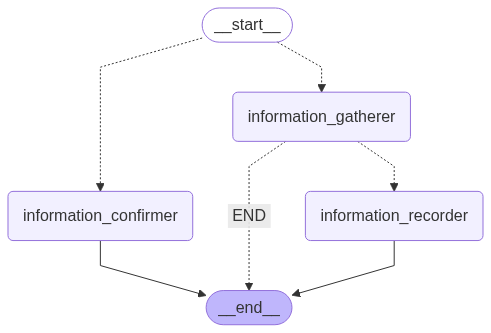

In [313]:
display(Image(main_graph.get_graph().draw_mermaid_png()))

In [314]:
def clean_state():
    return State(messages = [], initial_information = None,  record_initial_information = False, done_recording=False, itinerary_outline = None, itinerary_outline_feedback = None, itinerary_details = None, email_content = None, email = None, email_sent = False)

In [315]:
def make_thread_id() -> str:
    return str(uuid.uuid4())

async def process_message(message, history, state, thread):
    
    # first add the message to the state
    state["messages"].append(HumanMessage(content=message))
    print("state before invoke")
    print(state)
    config = {"configurable": {"thread_id": thread}, "recursion_limit": 100}
    
    new_state = await main_graph.ainvoke(state, config=config) # returns the state
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": "I was testing"}
    try:
        reply = {"role": "assistant", "content": new_state["messages"][-1].content}
    except IndexError:
        print("index error")
    # state["messages"].append(HumanMessage(content=message))
    print("state after invoke")
    print(new_state)
    # print("return of process message")
    # print(history + [user, reply])
    
    return "", history + [user, reply], new_state

async def reset():
    return "", "", make_thread_id(), clean_state()

async def generate_itinerary(state, history):
    # run the itinerary creation
    
    new_state = state

    feedback = {"role": "assistant", "content": "I was testing"}
    return "", history + [feedback], new_state


In [ ]:
state_0 = clean_state()

initial_information_test1 = InitialInformation(
    # email_address="1997.e.t@gmail.com",
    home_location=Location(country='USA', city='Chicago', address='123 Main St.'), 
    trip_locations=[Location(country='Italy', city='Florence', address='Piazza della Signoria 1, Florence'), Location(country='Japan', city='Kyoto', address='Kinkaku-ji Temple, Kyoto')], 
    start_date=date(2025, 12, 1), 
    end_date=date(2025, 12, 6), 
    duration=6, 
    num_adults=1, 
    num_children=0, 
    budget=5000, 
    other_preferences=['Enjoys trying new food'], 
    home_currency="USD",
    completed=True)
test_state1 = State(messages = [], initial_information = initial_information_test1, done_recording = False, record_initial_information=False, itinerary_details = None, itinerary_outline= None, itinerary_outline_feedback = None, email_content = None, email = None, email_sent = False)

with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Travel Planning Expert")
    thread = gr.State(make_thread_id())
    state = gr.State(state_0)

    with gr.Row():
        chatbot = gr.Chatbot(label="The agent", height=300, type="messages")
    with gr.Row():
        message = gr.Textbox(show_label=False, placeholder="Please start by letting us know where you would like to go!")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Send Message", variant="primary")
        confirm_information_button = gr.Button("My Info is correct", variant="secondary")
    message.submit(process_message, [message, chatbot, state, thread], [message, chatbot, state])
    go_button.click(process_message, [message, chatbot, state, thread], [message,chatbot, state])
    reset_button.click(reset, [], [message, chatbot, thread, state])
    confirm_information_button.click(generate_itinerary, [state], [message, chatbot, state])

    
demo.launch()

c:\Users\1997e\OneDrive\Desktop\Personal Projects\Agentic AI\travel agent\.venv\Lib\site-packages\gradio\utils.py:1038: UserWarning: Expected 2 arguments for function <function generate_itinerary at 0x000001D6720D2520>, received 1.
  warnings.warn(
c:\Users\1997e\OneDrive\Desktop\Personal Projects\Agentic AI\travel agent\.venv\Lib\site-packages\gradio\utils.py:1042: UserWarning: Expected at least 2 arguments for function <function generate_itinerary at 0x000001D6720D2520>, received 1.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7902
* To create a public link, set `share=True` in `launch()`.


state before invoke
{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={})], 'initial_information': None, 'record_initial_information': False, 'done_recording': False, 'itinerary_outline': None, 'itinerary_outline_feedback': None, 'itinerary_details': None, 'email_content': None, 'email': None, 'email_sent': False}
in information gathering agent
response:  {'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='f6394342-a438-45d0-b91f-e205d4887cc7'), AIMessage(content="Hello! I'm excited to help you plan your ideal trip! To get started, could you please share your email address?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 760, 'total_tokens': 785, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'mo